<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 90px">

# LCS 2020 Spring Analysis Notebook

#### (updated May 15)
#### _source: http://oracleselixir.com/_


###### _data dictionary: https://oracleselixir.com/matchdata/match-data-dictionary/_

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
pd.options.display.max_columns = 100
pd.options.display.max_rows = 3000

In [77]:
df = pd.read_csv('../datasets/2020_spring_match.csv')
df.head()

,gameid,url,league,split,date,game,patch,playerid,side,position,player,team,champion,ban1,ban2,ban3,ban4,ban5,gamelength,result,kills,deaths,assists,teamkills,teamdeaths,doublekills,triplekills,quadrakills,pentakills,firstblood,firstbloodkill,firstbloodassist,firstbloodvictim,team kpm,ckpm,firstdragon,dragons,opp_dragons,elementaldrakes,opp_elementaldrakes,infernals,mountains,clouds,oceans,dragons (type unknown),elders,opp_elders,heralds,opp_heralds,firstbaron,barons,opp_barons,firsttower,towers,opp_towers,firstmidtower,firsttothreetowers,inhibitors,opp_inhibitors,damagetochampions,dpm,damageshare,wardsplaced,wpm,wardskilled,wcpm,controlwardsbought,visionscore,vspm,totalgold,earnedgold,earned gpm,earnedgoldshare,goldspent,gspd,total cs,minionkills,monsterkills,monsterkillsownjungle,monsterkillsenemyjungle,cspm,goldat10,xpat10,csat10,opp_goldat10,opp_xpat10,opp_csat10,golddiffat10,xpdiffat10,csdiffat10,goldat15,xpat15,csat15,opp_goldat15,opp_xpat15,opp_csat15,golddiffat15,xpdiffat15,csdiffat15
0,5655-7249,http://lol.qq.com/match/match_data.shtml?bmid=...,LPL,2020-1,2020-01-13 09:22:22,1,10.01,1,Blue,top,TheShy,Invictus Gaming,Aatrox,Pantheon,Nautilus,Elise,Gangplank,Mordekaiser,2640,1,11,6,13,28,29,NaN,NaN,0.0,0.0,NaN,0.0,NaN,NaN,0.6364,1.2955,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42830.0,973.4091,0.297061,17.0,0.3864,7.0,0.1591,2.0,NaN,NaN,20569,14908,338.8182,0.275458,NaN,NaN,299.0,276.0,23.0,14.0,0.0,6.7955,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5655-7249,http://lol.qq.com/match/match_data.shtml?bmid=...,LPL,2020-1,2020-01-13 09:22:22,1,10.01,2,Blue,jng,Ning,Invictus Gaming,Qiyana,Pantheon,Nautilus,Elise,Gangplank,Mordekaiser,2640,1,0,7,11,28,29,NaN,NaN,0.0,0.0,NaN,0.0,NaN,NaN,0.6364,1.2955,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9984.0,226.9091,0.069247,66.0,1.5000,43.0,0.9773,15.0,NaN,NaN,13988,8327,189.2500,0.153858,NaN,NaN,285.0,83.0,202.0,134.0,16.0,6.4773,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5655-7249,http://lol.qq.com/match/match_data.shtml?bmid=...,LPL,2020-1,2020-01-13 09:22:22,1,10.01,3,Blue,mid,Rookie,Invictus Gaming,Rumble,Pantheon,Nautilus,Elise,Gangplank,Mordekaiser,2640,1,7,8,13,28,29,NaN,NaN,0.0,0.0,NaN,0.0,NaN,NaN,0.6364,1.2955,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38663.0,878.7045,0.268160,13.0,0.2955,8.0,0.1818,10.0,NaN,NaN,16447,10786,245.1364,0.199294,NaN,NaN,273.0,246.0,27.0,19.0,0.0,6.2045,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5655-7249,http://lol.qq.com/match/match_data.shtml?bmid=...,LPL,2020-1,2020-01-13 09:22:22,1,10.01,4,Blue,bot,Puff,Invictus Gaming,Senna,Pantheon,Nautilus,Elise,Gangplank,Mordekaiser,2640,1,8,3,17,28,29,NaN,NaN,0.0,0.0,NaN,0.0,NaN,NaN,0.6364,1.2955,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42401.0,963.6591,0.294086,12.0,0.2727,19.0,0.4318,3.0,NaN,NaN,20479,14818,336.7727,0.273795,NaN,NaN,343.0,319.0,24.0,19.0,2.0,7.7955,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5655-7249,http://lol.qq.com/match/match_data.shtml?bmid=...,LPL,2020-1,2020-01-13 09:22:22,1,10.01,5,Blue,sup,Southwind,Invictus Gaming,Braum,Pantheon,Nautilus,Elise,Gangplank,Mordekaiser,2640,1,2,5,21,28,29,NaN,NaN,0.0,0.0,NaN,0.0,NaN,NaN,0.6364,1.2955,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10301.0,234.1136,0.071446,70.0,1.5909,11.0,0.2500,21.0,NaN,NaN,10943,5282,120.0455,0.097594,NaN,NaN,37.0,37.0,0.0,0.0,0.0,0.8409,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [78]:
df.shape

(15312, 99)

In [79]:
# Renaming >>>
new_columns_dict = {
    'gameid': 'game_id_l',  # 
    'url': 'url_l',
    'league': 'league_c',
    'split': 'split_l',
    'date': 'date_t',
    'game': 'game_c',
    'patch': 'patch_l',
    'playerid': 'player_id_l',
    'side': 'map_side_b',
    'position': 'map_position_c', 
    'player': 'player_name_l', 
    'team': 'team_name_l', 
    'champion': 'player_champ_c',    # Is the champion the player is playing his top performing champion?  
    'ban1': 'team_ban1_c', 
    'ban2': 'team_ban2_c',
    'ban3': 'team_ban3_c', 
    'ban4': 'team_ban4_c', 
    'ban5': 'team_ban5_c', 
    'gamelength': 'game_seconds_n', 
    'result': 'result_b', 
    'kills': 'player_kills_n', 
    'deaths': 'player_deaths_n',
    'assists': 'player_assists_n', 
    'teamkills': 'team_kills_n', 
    'teamdeaths': 'team_deaths_n', 
    'doublekills': 'double_kills_n', 
    'triplekills': 'triple_kills_n',
    'quadrakills': 'quadra_kills_n', 
    'pentakills': 'penta_kills_n', 
    'firstblood': 'first_blood_b',  
    'firstbloodkill': 'first_blood_kill_b',
    'firstbloodassist': 'got_fb_assist_b', 
    'firstbloodvictim': 'was_fb_victim_b', 
    'team kpm': 'team_kpm_n', 
    'ckpm': 'combined_kpm_n',
    'firstdragon': 'first_dragon_b', 
    'dragons': 'dragons_n', 
    'opp_dragons': 'opponent_dragons_n', # opponent
    'elementaldrakes': 'ele_drakes_n',
    'opp_elementaldrakes': 'opp_ele_drakes_n', # opponent
    'infernals': 'infernal_drakes_n', 
    'mountains': 'mountain_drakes_n', 
    'clouds': 'cloud_drakes_n', 
    'oceans': 'ocean_drakes_n',
    'dragons (type unknown)': 'unknown_dragons_n', 
    'elders': 'elder_dragons_n', 
    'opp_elders': 'opp_elder_dragons_n', # opponent 
    'heralds': 'heralds_n',
    'opp_heralds': 'opp_heralds_n', # opponent
    'firstbaron': 'first_baron_b', 
    'barons': 'barons_n', 
    'opp_barons': 'opp_barons_n', # opponent
    'firsttower': 'first_tower_b',
    'towers': 'towers_n', 
    'opp_towers': 'opp_towers_n', # opponent
    'firstmidtower': 'first_midtower_b', 
    'firsttothreetowers': 'first_to_3towers_b',
    'inhibitors': 'inhibitors_n',
    'opp_inhibitors': 'opp_inhibitors_n', 
    'damagetochampions': 'damage_to_champs_n', 
    'dpm': 'damage_per_min_n',
    'damageshare': 'damage_share_n', # As %
    'wardsplaced': 'wards_placed_n', 
    'wpm': 'wards_per_min_n', 
    'wardskilled': 'wards_destroyed_n', 
    'wcpm': 'wards_cleared_per_min_n',
    'controlwardsbought': 'control_wards_bought_n', 
    'visionscore': 'total_vision_score_n', # TIL!!!
    'vspm': 'vision_score_per_min_n', 
    'totalgold': 'total_gold_n', 
    'earnedgold': 'gold_earned_n',
    'earned gpm': 'gold_per_min_n', 
    'earnedgoldshare': 'gold_share_n', # Share of team’s total gold, with starting gold and inherent gold generation removed.
    'goldspent': 'gold_spent_n', 
    'gspd': 'gold_spend_%_dif', # (Team A Gold Spent - Team B Gold Spent) / (Gold Spent Average for both) >>> see: https://oracleselixir.com/2015/07/measuring-the-margins-gold-spent-percentage-difference/.
    'total cs': 'total_creep_score_n', # All creep score variables include minions and monsters, and do not include wards, champion-generated minions, or other units counted as CS in-game.
    'minionkills': 'lane_minions_killed_n', 
    'monsterkills': 'monsters_killed_n', 
    'monsterkillsownjungle': 'own_jungle_monsters_n',
    'monsterkillsenemyjungle': 'opp_jungle_monsters_n', 
    'cspm': 'creep_score_per_min_n', 
    'goldat10': 'gold_at_10min_m_n', 
    'xpat10': 'exp_at_10min_n', 
    'csat10': 'creep_score_at_10min_n',
    'opp_goldat10': 'opp_gold_at_10min_n', 
    'opp_xpat10': 'opp_exp_at_10min_n', 
    'opp_csat10': 'opp_creep_score_at_10min_n', 
    'golddiffat10': 'gold_diff_at_10min_n',
    'xpdiffat10': 'exp_diff_at_10min_n', 
    'csdiffat10': 'creep_score_at_10min_n', 
    'goldat15': 'gold_at_15min_n', 
    'xpat15': 'exp_at_15min_n',
    'csat15': 'creep_score_at_15min_n',
    'opp_goldat15': 'opp_gold_at_15min_n',
    'opp_xpat15': 'opp_exp_at_15min_n', 
    'opp_csat15': 'opp_creep_score_at_15min_n', 
    'golddiffat15': 'gold_diff_at_15min_n',
    'xpdiffat15': 'exp_diss_at_15min_n', 
    'csdiffat15': 'creep_score_difff_at_15min_n'}

df.rename(columns=new_columns_dict, inplace=True)

# Legend: 
    # _l > Label(game)/ Record Identifier
    # _c > category/ class
    # _t > time/ Time Identifier
    # _n > number/ sample
    # _b > binary/ (yes|no)

In [80]:
print(df.dtypes[0:20])
print(df.dtypes[21:40])
print(df.dtypes[41:60])
print(df.dtypes[61:80])
print(df.dtypes[81:100])

game_id_l          object
url_l              object
league_c           object
split_l            object
date_t             object
game_c              int64
patch_l           float64
player_id_l         int64
map_side_b         object
map_position_c     object
player_name_l      object
team_name_l        object
player_champ_c     object
team_ban1_c        object
team_ban2_c        object
team_ban3_c        object
team_ban4_c        object
team_ban5_c        object
game_seconds_n      int64
result_b            int64
dtype: object
player_deaths_n         int64
player_assists_n        int64
team_kills_n            int64
team_deaths_n           int64
double_kills_n        float64
triple_kills_n        float64
quadra_kills_n        float64
penta_kills_n         float64
first_blood_b         float64
first_blood_kill_b    float64
got_fb_assist_b       float64
was_fb_victim_b       float64
team_kpm_n            float64
combined_kpm_n        float64
first_dragon_b        float64
dragons_n       

In [81]:
# Change date to date/time. 
df['date_t'] = pd.to_datetime(df['date_t'])

# Convert map_side_c to {'Blue': 0, 'Red': 1}
df['map_side_b'] = df['map_side_b'].map({'Blue': 0, 'Red': 1}) 

# Assign map positions: {'team': 0, 'bot': 1, 'mid': 2, 'top': 3, 'sup': 4, 'jng': 5}
df['map_position_c'] = df['map_position_c'].map({'team': 0, 'bot': 1, 'mid': 2, 'top': 3, 'sup': 4, 'jng': 5}) 

In [82]:
# Export clean dataset >>>
df.to_csv('../datasets/clean_df.csv', index=False)

# Initial Team Analysis: Result Oriented Logistic Regression 

In [83]:
team_df = df
team_df.isnull().sum().sort_values(ascending=False)
# We can fill the Null values with 0s since we dont want them to impact our model >>>
team_df = team_df.fillna(0)

In [65]:
# plt.hist(team_df[team_df['ticker'] == 'GOOG']['close'], bins=30);
# team_df['unknown_dragons_n'] = team_df['unknown_dragons_n'].map({'FV': 7, 'RL': 6, 'RH': 5, 'RM': 4, 'C (all)': 3, 'I (all)': 2, 'A (agr)': 1})


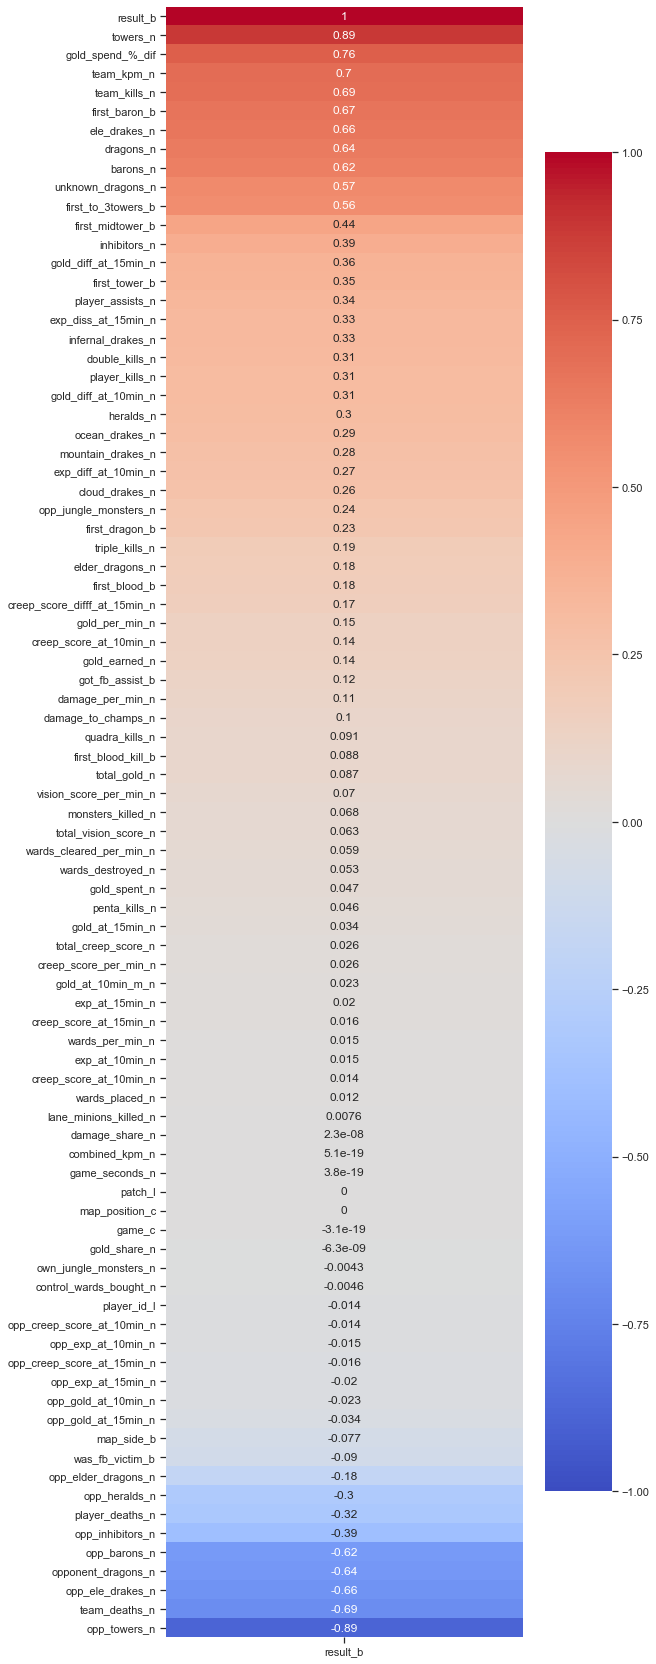

In [85]:
# Plot heatmap >>>
plt.figure(figsize=(8,30)) 
sns.heatmap(df.corr()[['result_b']].sort_values('result_b', ascending=False),
            annot=True,
            cmap = 'coolwarm',
            vmin = -1,
            vmax = 1);

In [95]:
ls

 Volume in drive C has no label.
 Volume Serial Number is 18E0-9658

 Directory of C:\Users\Vic\Desktop\GA_master\Projects\Project_6_capstone\notebooks

06/06/2020  12:06 PM    <DIR>          .
06/06/2020  12:06 PM    <DIR>          ..
05/28/2020  03:45 PM    <DIR>          .ipynb_checkpoints
06/06/2020  12:06 PM           415,604 p6_League_of_Legends_nb.ipynb
               1 File(s)        415,604 bytes
               3 Dir(s)  28,565,467,136 bytes free


In [94]:
# Set up your X and y columns >>>
X = team_df._get_numeric_data().drop(columns='result_b')
features = list(X.columns)
y = team_df['result_b']

# Train/ test split >>>
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# # Log our target >>>
# y_train_log = y_train.map(np.log)
# y_test_log = y_test.map(np.log)

# Instantiate models >>>
logreg = LogisticRegression()

# Cross val score >>>
logreg.fit(X_train, y_train);
# Train score
print('train', logreg.score(X_train, y_train))
# Test score
print('test', logreg.score(X_test, y_test))
# cross val score
print('cv', cross_val_score(logreg, X_train, y_train, cv=10).mean())

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

train 0.8171368861024033
test 0.8239289446185998


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

cv 0.8111309485903512


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

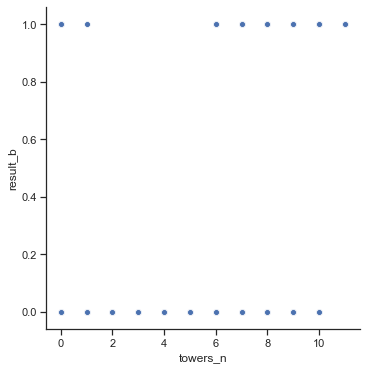

In [68]:
# # Lets look at a pairplot numerical features>>>
# sns.set(style="ticks", color_codes=True)
# sns.pairplot(team_df, height=5, x_vars=['towers_n'], y_vars=['result_b']);

In [3]:
df['team'].value_counts()

DragonX             330
DAMWON Gaming       306
T1                  306
SANDBOX Gaming      306
Top Esports         300
                   ... 
Beşiktaş Esports    102
Royal Youth          96
5 Ronin              96
Seorabeol Gaming     48
Team Dynamics        24
Name: team, Length: 86, dtype: int64

In [61]:
# Blue side tends to win 4% more than red side. Blue side winning confirmation >>>
df.groupby('result')['side'].value_counts(normalize=True)

result  side
0       Red     0.538401
        Blue    0.461599
1       Blue    0.538401
        Red     0.461599
Name: side, dtype: float64

In [62]:
# Patch breakdown >>>
df['patch'].value_counts()

10.06    4116
10.05    2484
10.04    2292
10.07    1728
10.02    1716
10.03    1632
10.01     876
10.08     468
Name: patch, dtype: int64

In [65]:
# Position breakdown >>>
df['position'].value_counts()

jng     2552
mid     2552
sup     2552
top     2552
team    2552
bot     2552
Name: position, dtype: int64

In [68]:
# Players surveyed in this dataset >>>
df['player'].value_counts().count()

537

In [72]:
df.groupby('team')['result'].sum().sort_values(ascending=False).head(20)

team
T1                     216
DragonX                210
FunPlus Phoenix        198
JD Gaming              192
Gen.G                  186
Top Esports            186
Invictus Gaming        174
Cloud9                 156
G2 Esports             156
DAMWON Gaming          156
Talon Esports          156
EDward Gaming          150
KT Rolster             150
eStar                  144
Team WE                144
Machi Esports          138
ahq eSports Club       132
SANDBOX Gaming         126
Royal Never Give Up    126
Vici Gaming            126
Name: result, dtype: int64

### Numerics: 

In [51]:
df['game'].value_counts()

1    9672
2    3372
3    1824
4     324
5     120
Name: game, dtype: int64

In [58]:
df.groupby('team')['kills'].mean().sort_values(ascending=False)

team
G2 Esports          6.372549
Cloud9 Academy      6.293333
Cloud9              5.678571
eStar               5.569106
Vivo Keyd           5.305556
                      ...   
Griffin             2.886667
Immortals           2.877193
Golden Guardians    2.818182
SK Gaming           2.611111
Seorabeol Gaming    2.416667
Name: kills, Length: 86, dtype: float64

### Leagues: 

#### Ranking Dragon Buffs:

In [76]:
# every dragon will have a different benefit score

### Looks like we have 8 different leagues: 

- LPL (4284) - Tencent League of Legends Pro League (China)
- LCK (3000) - League of Legends Champions Korea (Korea)
- PCS (1584) - Pacific Championship Series (Pacific countries, thai, etc)
- LCS (1500) - League of Legends Championship Series (US)
- LEC (1452) - League of Legends European Championship (EU)
- LCS.A (1284) - League of Legends Championship Series .A ?  (US?)
- CBLOL (1116) - Campeonato Brasileiro de League of Legends (South America)
- TCL (1092) - Turkish Championship League (Turkey)

In [80]:
df.groupby('league')['player'].value_counts().head(50)

league  player     
CBLOL   Absolut        27
        Ceos           27
        Goku           27
        Parang         27
        Ranger         27
        Tutsz          27
        Wiz            27
        WooFe          27
        Anyyy          24
        Damage         24
        Klaus          24
        NOsFerus       24
        Professor      24
        Robo           24
        Alternative    23
        Grell          22
        Aloned         21
        Garo           21
        Key            21
        Krastyel       21
        SeongHwan      21
        Wos            21
        Yampi          21
        Yang           21
        brTT           21
        fNb            21
        tinowns        21
        Shini          20
        BocaJR         19
        DudsTheBoy     19
        Minerva        19
        Patrick        19
        RedBert        19
        JoJo           17
        Tyrin          17
        micaO          16
        Hauz           12
        Sephis    

In [6]:
df['league'].value_counts()

LPL      4284
LCK      3000
PCS      1584
LCS      1500
LEC      1452
LCS.A    1284
CBLOL    1116
TCL      1092
Name: league, dtype: int64

### Splits:  Only 2020-1 for this dataset.

In [10]:
df['split'].value_counts()

2020-1    15312
Name: split, dtype: int64

In [7]:
# df.groupby('player' == 'knight')

# How many seconds of phone calls are recorded in total?
df['kills'][df['player'] == 'knight'].sum()

246

In [23]:
df['champion'].value_counts().head(10)

Miss Fortune    609
Nautilus        502
Aatrox          480
Aphelios        474
Ornn            465
Sett            435
Jarvan IV       415
Varus           407
Lee Sin         364
Braum           360
Name: champion, dtype: int64

In [13]:
df['champion'][(df['player'] == 'knight') & (df['champion'] == 'Ekko')]

9907     Ekko
14258    Ekko
Name: champion, dtype: object

In [20]:
df.groupby('result')['champion'].value_counts().sort_values(ascending=False).head(10)

result  champion    
0       Miss Fortune    305
1       Miss Fortune    304
0       Nautilus        268
1       Aphelios        259
0       Aatrox          248
1       Ornn            238
        Nautilus        234
        Aatrox          232
        Sett            228
0       Ornn            227
Name: champion, dtype: int64

In [14]:
df.groupby(['league', 'team', 'player'])['kills'].sum().sort_values(ascending=False).head(10)

league  team             player 
LPL     Top Esports      knight     246
        Team WE          Jiumeng    236
LCK     DragonX          Deft       225
LPL     Invictus Gaming  Puff       223
        FunPlus Phoenix  Lwx        223
        EDward Gaming    Hope       220
        FunPlus Phoenix  Doinb      215
        eStar            Cryin      214
LCK     T1               Teddy      211
LPL     eStar            Wink       190
Name: kills, dtype: int64

In [16]:
df.groupby(['league', 'team'])['kills'].sum().sort_values(ascending=False).head(10)

league  team           
LPL     Top Esports        1504
        FunPlus Phoenix    1492
        Invictus Gaming    1426
LCK     DragonX            1412
LPL     Team WE            1372
        eStar              1370
LEC     G2 Esports         1300
LPL     JD Gaming          1258
LCK     T1                 1238
LPL     EDward Gaming      1232
Name: kills, dtype: int64

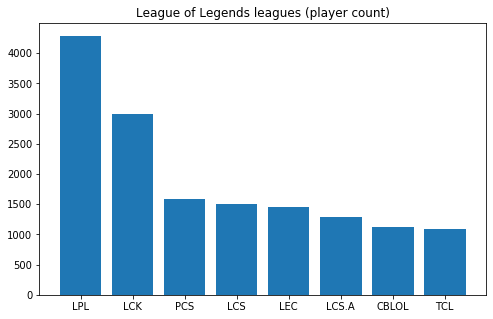

In [39]:
# Number of players in each LCS league/region

plt.figure(figsize=(8, 5))
plt.bar(['LPL', 'LCK', 'PCS', 'LCS', 'LEC', 'LCS.A', 'CBLOL', 'TCL'],
        df['league'].value_counts())
plt.title('League of Legends leagues (player count)');

In [ ]:
# Number of players in each LCS league/region

plt.figure(figsize=(8, 5))
plt.bar(['LPL', 'LCK', 'PCS', 'LCS', 'LEC', 'LCS.A', 'CBLOL', 'TCL'],
        df['league'].value_counts())
plt.title('League of Legends leagues (player count)');

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15312 entries, 0 to 15311
Data columns (total 99 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   gameid                   15312 non-null  object 
 1   url                      15312 non-null  object 
 2   league                   15312 non-null  object 
 3   split                    15312 non-null  object 
 4   date                     15312 non-null  object 
 5   game                     15312 non-null  int64  
 6   patch                    15312 non-null  float64
 7   playerid                 15312 non-null  int64  
 8   side                     15312 non-null  object 
 9   position                 15312 non-null  object 
 10  player                   12760 non-null  object 
 11  team                     15312 non-null  object 
 12  champion                 12760 non-null  object 
 13  ban1                     15060 non-null  object 
 14  ban2                  

In [37]:
df['gameid'].value_counts().head(50)

ESPORTSTMNT06/1170687    12
ESPORTSTMNT05/1440709    12
ESPORTSTMNT01/1301290    12
ESPORTSTMNT01/1293909    12
5964-7333                12
ESPORTSTMNT05/1440421    12
ESPORTSTMNT01/1294813    12
6061-7523                12
5993-7400                12
ESPORTSTMNT03/1350888    12
ESPORTSTMNT03/1331601    12
ESPORTSTMNT05/1430696    12
5986-7384                12
ESPORTSTMNT02/1281254    12
6076-7572                12
ESPORTSTMNT02/1322969    12
ESPORTSTMNT02/1286996    12
ESPORTSTMNT04/1140351    12
ESPORTSTMNT03/1342212    12
6096-7677                12
ESPORTSTMNT01/1325904    12
6125-7717                12
ESPORTSTMNT03/1334863    12
6071-7558                12
ESPORTSTMNT02/1295837    12
ESPORTSTMNT05/1430677    12
ESPORTSTMNT06/1170254    12
ESPORTSTMNT03/1301228    12
ESPORTSTMNT02/1324713    12
6094-7663                12
ESPORTSTMNT05/1430676    12
ESPORTSTMNT02/1331076    12
ESPORTSTMNT01/1313895    12
ESPORTSTMNT02/1334673    12
5973-7353                12
ESPORTSTMNT05/143065

In [25]:
df.groupby('game').describe()

patch                                                         playerid  \
       count       mean       std    min    25%    50%    75%    max    count   
game                                                                            
1     9672.0  10.043337  0.018199  10.01  10.03  10.04  10.06  10.08   9672.0   
2     3372.0  10.050107  0.017137  10.01  10.04  10.06  10.06  10.08   3372.0   
3     1824.0  10.052434  0.017849  10.01  10.04  10.06  10.06  10.08   1824.0   
4      324.0  10.065926  0.006251  10.06  10.06  10.07  10.07  10.08    324.0   
5      120.0  10.068000  0.006025  10.06  10.06  10.07  10.07  10.08    120.0   

                 ... xpdiffat15         csdiffat15                         \
           mean  ...        75%     max      count mean        std    min   
game             ...                                                        
1     29.583333  ...     526.00  6199.0     7944.0  0.0  28.939944 -155.0   
2     29.583333  ...     536.00  5909.0     1668.0  0.0  32.003149 -143.0   
3     29.583333  ...     504.75  6969.0     1032.0  0.0  30.234326 -143.0   
4     29.583333  ...     616.25  3732.0      240.0  0.0  31.013562 -123.0   
5     29.583333  ...     669.75  3665.0      108.0  0.0  29.726479  -96.0   

                                
        25%  50%    75%    max  
game                            
1    -12.00  0.0  12.00  155.0  
2    -12.00  0.0  12.00  143.0  
3    -13.00  0.0  13.00  143.0  
4    -14.00  0.0  14.00  123.0  
5    -14.25  0.0  14.25   96.0  

[5 rows x 664 columns]

In [50]:
'''
Cloud9 and Cloud9 Academy teams are definately very strong contenders at the moment. With 92% average wins for Cloud9 and 80% for Cloud9 Academy, that is pretty impressive. 
But what does pinnacle say? 
'''


df.groupby('team')['result'].describe().tail(60)

,count,mean,std,min,25%,50%,75%,max
team,,,,,,,,
Flamengo eSports,162.0,0.592593,0.492875,0.0,0.0,1.0,1.00,1.0
FlyQuest,228.0,0.526316,0.500406,0.0,0.0,1.0,1.00,1.0
FlyQuest Academy,108.0,0.388889,0.489771,0.0,0.0,0.0,1.00,1.0
Fnatic,168.0,0.678571,0.468421,0.0,0.0,1.0,1.00,1.0
FunPlus Phoenix,300.0,0.660000,0.474500,0.0,0.0,1.0,1.00,1.0
G2 Esports,204.0,0.764706,0.425226,0.0,1.0,1.0,1.00,1.0
Galakticos,114.0,0.421053,0.495908,0.0,0.0,0.0,1.00,1.0
Gen.G,282.0,0.659574,0.474695,0.0,0.0,1.0,1.00,1.0
Golden Guardians,132.0,0.409091,0.493539,0.0,0.0,0.0,1.00,1.0


In [ ]:
# convert date to date time? 

df['date'].

In [22]:
df['date'].plot(kind = 'line')

TypeError: no numeric data to plot

In [7]:
df['position'].value_counts()

top     2552
sup     2552
jng     2552
bot     2552
team    2552
mid     2552
Name: position, dtype: int64

In [8]:
df['champion'].value_counts(ascending=True)

Lux               1
Nunu              1
Garen             1
Rengar            1
Teemo             1
               ... 
Ornn            465
Aphelios        474
Aatrox          480
Nautilus        502
Miss Fortune    609
Name: champion, Length: 134, dtype: int64

In [9]:
df['player'].value_counts(ascending=True)

Naehyun       1
Pocky         1
Copy Catt     1
melody        1
Kabuu         1
             ..
Doran        52
Deft         55
Chovy        55
Keria        55
Pyosik       55
Name: player, Length: 537, dtype: int64

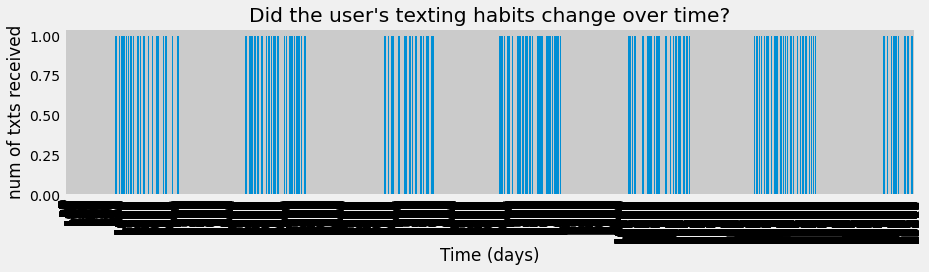

In [12]:
# EDA plot example >>> local bayes

plt.style.use('fivethirtyeight')
plt.figure(figsize = (13, 4))
df['result'].plot(kind = 'bar')
plt.title('Did the user\'s texting habits change over time?')
plt.xlabel('Time (days)')
plt.ylabel('num of txts received')
plt.tight_layout()

In [ ]:
# Loc first 19 rows >>>

df.loc[:19, 'kills'].mean()

In [15]:
# Groupbys

df.groupby('team')['result'].mean().sort_values(ascending=False)

team
Team Dynamics              1.000000
Cloud9                     0.928571
Cloud9 Academy             0.800000
1907 Fenerbahçe Esports    0.791667
G2 Esports                 0.764706
                             ...   
SK Gaming                  0.222222
5 Ronin                    0.187500
Counter Logic Gaming       0.166667
Team Vitality              0.111111
Victory Five               0.030303
Name: result, Length: 86, dtype: float64

## Modeling Process & Feature Engineering:

In [75]:
# Cut out top 20 teams for analysis >>>
df.groupby('team')['result'].sum().sort_values(ascending=False).head(20)

team
T1                     216
DragonX                210
FunPlus Phoenix        198
JD Gaming              192
Gen.G                  186
Top Esports            186
Invictus Gaming        174
Cloud9                 156
G2 Esports             156
DAMWON Gaming          156
Talon Esports          156
EDward Gaming          150
KT Rolster             150
eStar                  144
Team WE                144
Machi Esports          138
ahq eSports Club       132
SANDBOX Gaming         126
Royal Never Give Up    126
Vici Gaming            126
Name: result, dtype: int64